# Linear Registration with Images

This notebook is adapted from [Daniel's tutorial](https://github.com/dtward/image-registration-summer-school-2018/blob/master/linear-transformations-images.ipynb).

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import scipy.interpolate as spi

import utility as util

## Load and preprocess images

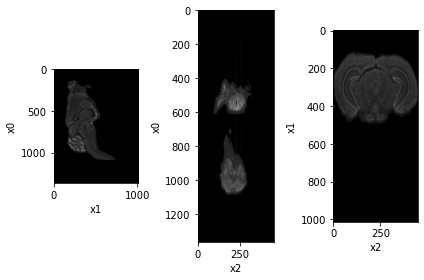

In [2]:
I = np.load('../data/local/MD585_CH1.npy')
I = util.normalize_intensity(I)
util.imshow_midslice(I)

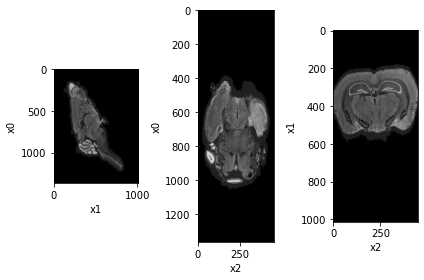

In [3]:
J = np.load('../data/local/MD589_CH1.npy')
J = util.normalize_intensity(J)
util.imshow_midslice(J)

## Linear registration

Currently, it takes too long to run. Cannot finish a single iteration in 30 min on ratto.

In [4]:
def sample_points_from_affine(X0,X1,X2,A):
    ''' From affine matrix A, 
    and meshgrid domain X0, X1, X2,
    construct sample points used to interpolate an image at to apply deformation
    '''
    B = np.linalg.inv(A)
    # get the sample points by matrix multiplication
    X0s = B[0,0]*X0 + B[0,1]*X1 + B[0,2]*X2 + B[0,3]
    X1s = B[1,0]*X0 + B[1,1]*X1 + B[1,2]*X2 + B[1,3]
    X2s = B[2,0]*X0 + B[2,1]*X1 + B[2,2]*X2 + B[2,3]
    return X0s,X1s,X2s  

In [5]:
# set up a domain, a grid of points describing the locations of each voxel
nx = I.shape # number of voxels
dx = [1, 1, 1] # size of each voxel
x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
x2 = np.arange(nx[2])*dx[2]

# lets define the origin to be in the middle of our image
# linear transformations will be more reasonable this way
# i.e. we'll rotate around the middle, instead of rotating around a corner
x0 = x0 - np.mean(x0)
x1 = x1 - np.mean(x1)
x2 = x2 - np.mean(x2)
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')

# set some arguments that will be used for interpolation with a dictionary
interp_args = {
    'method':'linear', # this says how we'd like to do interpolation, linear is fast and smooth
    'bounds_error':False, # if we try to sample outside the image, do not raise an error    
    'fill_value':None # if we try to sample outside the image, we'll return the nearest pixel value
}

In [ ]:
A = np.eye(4)

epsilonL = 3.0e-5
epsilonT = 3.0e-4
niter = 25

EAll = [] # the energy, for plotting
f,ax = plt.subplots(3,3) # a figure for plotting
plt.subplots_adjust(wspace=0.45,hspace=0.45) # make the figure have a nicer layout
for it in range(niter):
    print(it)
    # find the deformed image, by deforming the grid with the inverse, and using interpolation
    X0s,X1s,X2s = sample_points_from_affine(X0,X1,X2,A)
    AI = spi.interpn([x0,x1,x2],I,np.stack([X0s,X1s,X2s],axis=-1),**interp_args)
    
    # visualize it, we show the deforming atlas on the first row
    util.imshow_midslice(AI,ax[0])
    
    # get the error
    err = AI-J
    
    # we show the error on the second row
    util.imshow_midslice(err,ax[1])
    for a in ax[1]: a.set_xlabel('')
    
    # find the image gradient.  This is the discrete centered difference, with given voxel size
    AI_0,AI_1,AI_2 = np.gradient(AI,dx[0],dx[1],dx[2])
    
    # calculate energy and plot it
    E = np.sum(err**2*0.5)*np.prod(dx)
    EAll.append(E)
    ax[2,0].cla()
    ax[2,0].plot(EAll)
    ax[2,0].set_title('cost')
    ax[2,0].set_xlabel('iteration')
    
    # find the Energy gradient of the linear part using our derivation above
    gradL = np.empty((3,3))
    for i,AI_i in enumerate([AI_0,AI_1,AI_2]):
        for j,AX_j in enumerate([X0s,X1s,X2s]):
            gradL[i,j] = -np.sum(err*AI_i*AX_j)*np.prod(dx)
            
    # find the Energy gradient of the translation part using our derivation above
    gradT = np.empty(3)
    for i,AI_i in enumerate([AI_0,AI_1,AI_2]):
        gradT[i] = -np.sum(err*AI_i)*np.prod(dx)
        
    # update using gradient descent
    A[:3,:3] -= epsilonL*gradL
    A[:3,-1] -= epsilonT*gradT
    
    # draw it in real time
    f.canvas.draw()

0
